# Setup

In [1]:
import argparse
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from tqdm.auto import tqdm
import matplotlib
import traceback
import sys

from utils import *
from compare_uid import *
matplotlib.use('nbAgg')

c:\Users\Tianqi Zhang\Desktop\Balancing-The-Flow\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to C:\Users\Tianqi
[nltk_data]     Zhang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
%matplotlib inline

# Data Prep

In [3]:
UID_metrics = load_metrics_files(Path("../UID_Analysis").iterdir())

Loaded metrics from human_texts: 2000 texts
Loaded metrics from llama-2-7b: 2000 texts
Loaded metrics from llama-2-7b-32k-instruct: 300 texts
Loaded metrics from llama-2-7b-chat: 300 texts
Loaded metrics from mistral-7b-instruct-v0.3: 300 texts
Loaded metrics from mistral-7b-v0.1: 300 texts
Loaded metrics from mistral-instruct-01: 300 texts
Loaded metrics from mistral-plus-7b: 300 texts


In [4]:
human = ['human_texts']
base_lm = [
    'llama-2-7b', 
    'mistral-7b-v0.1',
    ]
instruct = [
    'llama-2-7b-32k-instruct',
    # 'mistral-7b-instruct-v0.3', 
    'mistral-instruct-01',
    ]
chat = ['llama-2-7b-chat', 'mistral-plus-7b']

UID_metrics['model_class'] = UID_metrics['model'].apply(lambda model: 'human' if model in human 
                                                      else 'base' if model in base_lm
                                                      else 'instruct' if model in instruct 
                                                      else 'chat' if model in chat
                                                      else 'other')
UID_metrics = UID_metrics[UID_metrics['model_class'] != 'other']

In [5]:
# subsampling based on model and model class
subsamp_model = (UID_metrics.groupby('model')
                .apply(lambda df: df.sample(300, replace=False, random_state=42))
                .reset_index(drop=True))
subsamp_model_class = (UID_metrics.groupby('model_class')
                    .apply(lambda df: df.sample(600, replace=False, random_state=42))
                    .reset_index(drop=True))
subsamp_model_class['model_class'].value_counts()

C:\Users\Tianqi Zhang\AppData\Local\Temp\ipykernel_29836\494611788.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.sample(300, replace=False, random_state=42))
C:\Users\Tianqi Zhang\AppData\Local\Temp\ipykernel_29836\494611788.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.sample(600, replace=False, random_state=42))


model_class
base        600
chat        600
human       600
instruct    600
Name: count, dtype: int64

In [14]:
UID_metrics.head()

,filename,tokens,mean_surprisal,median_surprisal,min_surprisal,max_surprisal,uid_variance,uid_pairwise,model,model_class
0,human_0.csv,562,4.340188,3.270889,1.324272e-05,18.593735,16.341262,31.181234,human_texts,human
1,human_1.csv,885,4.313564,3.413249,2.887018e-04,19.398069,14.362096,29.931362,human_texts,human
2,human_10.csv,950,3.970930,2.902300,1.604687e-04,27.686630,14.211679,27.792369,human_texts,human
3,human_100.csv,280,3.786593,2.551521,5.503455e-06,23.138186,16.190438,28.571763,human_texts,human
4,human_1000.csv,943,4.527349,3.571090,5.159480e-07,23.205757,16.419139,34.817292,human_texts,human


In [16]:
UID_metrics.set_index('filename')['uid_pairwise'].idxmax()

'mistral-7b-v0.1_162.csv'

# Visualizations

In [6]:
UID_metrics.head()

,filename,tokens,mean_surprisal,median_surprisal,min_surprisal,max_surprisal,uid_variance,uid_pairwise,model,model_class
0,human_0.csv,562,4.340188,3.270889,1.324272e-05,18.593735,16.341262,31.181234,human_texts,human
1,human_1.csv,885,4.313564,3.413249,2.887018e-04,19.398069,14.362096,29.931362,human_texts,human
2,human_10.csv,950,3.970930,2.902300,1.604687e-04,27.686630,14.211679,27.792369,human_texts,human
3,human_100.csv,280,3.786593,2.551521,5.503455e-06,23.138186,16.190438,28.571763,human_texts,human
4,human_1000.csv,943,4.527349,3.571090,5.159480e-07,23.205757,16.419139,34.817292,human_texts,human


In [7]:
subsamp_model_class.groupby("model_class").apply(lambda df: df.describe().loc[['mean', 'std']])

C:\Users\Tianqi Zhang\AppData\Local\Temp\ipykernel_29836\2673705511.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subsamp_model_class.groupby("model_class").apply(lambda df: df.describe().loc[['mean', 'std']])


tokens  mean_surprisal  median_surprisal  min_surprisal  \
model_class                                                                     
base        mean  148.385000        4.568988          3.405095       0.123841   
            std   207.819019        1.508467          1.860247       0.482802   
chat        mean  129.411667        3.839704          2.901653       0.007588   
            std    80.788242        0.589843          0.602489       0.040061   
human       mean  764.816667        4.436541          3.369177       0.000243   
            std   249.483647        0.418099          0.476619       0.000513   
instruct    mean  284.568333        3.874761          3.006637       0.068501   
            std   336.520121        1.342988          1.549353       0.373264   

                  max_surprisal  uid_variance  uid_pairwise  
model_class                                                  
base        mean      20.721446     21.681264     41.004377  
            std       11.012188     38.084416     75.108475  
chat        mean      17.767360     12.856076     24.964860  
            std        4.724595      3.745989      7.483619  
human       mean      22.088832     16.583172     32.094296  
            std        2.722942      2.085283      4.292582  
instruct    mean      17.751416     12.317210     24.282366  
            std        5.210107      5.121935     13.640650

In [38]:
UID_metrics['model'].value_counts()

model
human_texts                2000
llama-2-7b                 2000
llama-2-7b-32k-instruct     300
llama-2-7b-chat             300
mistral-7b-v0.1             300
mistral-instruct-01         300
mistral-plus-7b             300
Name: count, dtype: int64

In [99]:
main_cmap = {
    'human': 'green',
    'base': 'steelblue',
    'instruct': 'firebrick',
    'chat': 'orange',
}
main_cmap.update({
    'human_texts': main_cmap['human'],
    ####
    'llama-2-7b': main_cmap['base'],
    'mistral-7b-v0.1': main_cmap['base'],
    ####
    'llama-2-7b-32k-instruct': main_cmap['instruct'],
    'mistral-instruct-01': main_cmap['instruct'],
    ####
    'llama-2-7b-chat': main_cmap['chat'],
    'mistral-plus-7b': main_cmap['chat']
})

Text(0.5, 1.0, 'Mean vs. median surprisal values')

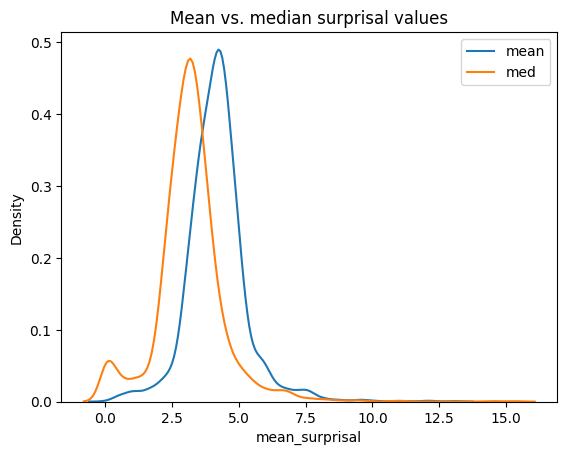

In [100]:
sns.kdeplot(data=subsamp_model_class, x='mean_surprisal', label='mean')
sns.kdeplot(data=subsamp_model_class, x='median_surprisal', label='med')
plt.legend()
plt.title("Mean vs. median surprisal values")

(0.0, 1024.0)

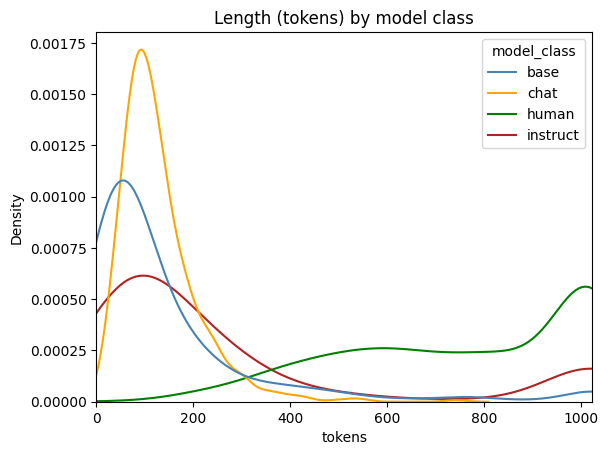

In [101]:
sns.kdeplot(data=subsamp_model_class, x='tokens', hue='model_class', palette=main_cmap)
plt.title("Length (tokens) by model class")
plt.xlim(0, 1024)

<Axes: xlabel='mean_surprisal', ylabel='Density'>

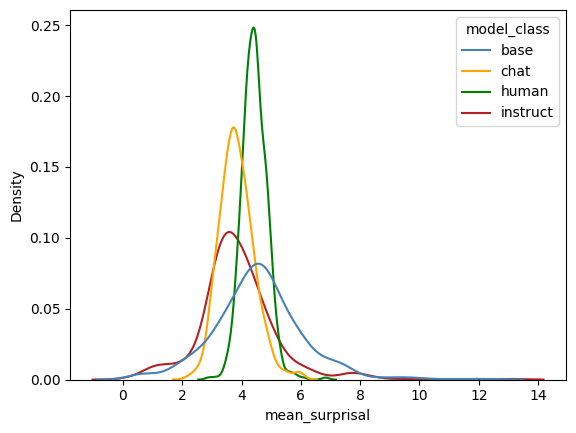

In [ ]:

sns.kdeplot(data=subsamp_model_class, x='mean_surprisal', hue='model_class', palette=main_cmap)

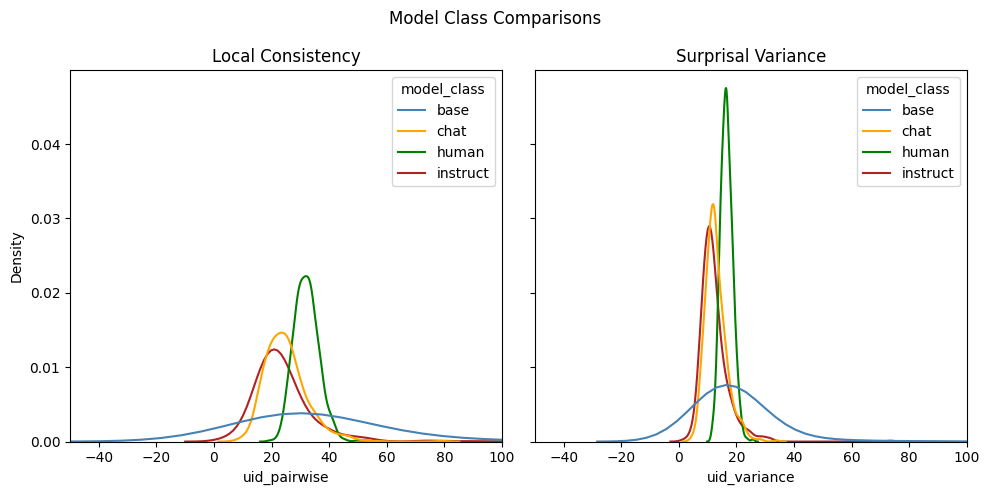

In [103]:
def plot_uid_measures(df, hue='model', titles=("Local consistency", "Surprisal variance"), suptitle="", cmap=None):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

    sns.kdeplot(data=df, x='uid_pairwise', hue=hue, ax=axs[0], palette=cmap)
    axs[0].set_xlim(-50, 100)
    axs[0].set_title(titles[0].title())

    sns.kdeplot(data=df, x='uid_variance', hue=hue, ax=axs[1], palette=cmap)
    axs[1].set_title(titles[1].title())

    plt.suptitle(suptitle.title())
    plt.tight_layout()
plot_uid_measures(subsamp_model_class, hue='model_class', suptitle='Model Class Comparisons', cmap=main_cmap)

In [104]:
UID_metrics['model'].value_counts()

model
human_texts                2000
llama-2-7b                 2000
llama-2-7b-32k-instruct     300
llama-2-7b-chat             300
mistral-7b-v0.1             300
mistral-instruct-01         300
mistral-plus-7b             300
Name: count, dtype: int64

In [105]:
llama_models = ['llama-2-7b', 'llama-2-7b-32k-instruct', 'llama-2-7b-chat']
mistral_models = ['mistral-7b-v0.1', 'mistral-instruct-01', 'mistral-plus-7b']

llama_metrics = subsamp_model[subsamp_model['model'].isin(llama_models + ['human_texts'])]
mistral_metrics = subsamp_model[subsamp_model['model'].isin(mistral_models + ['human_texts'])]

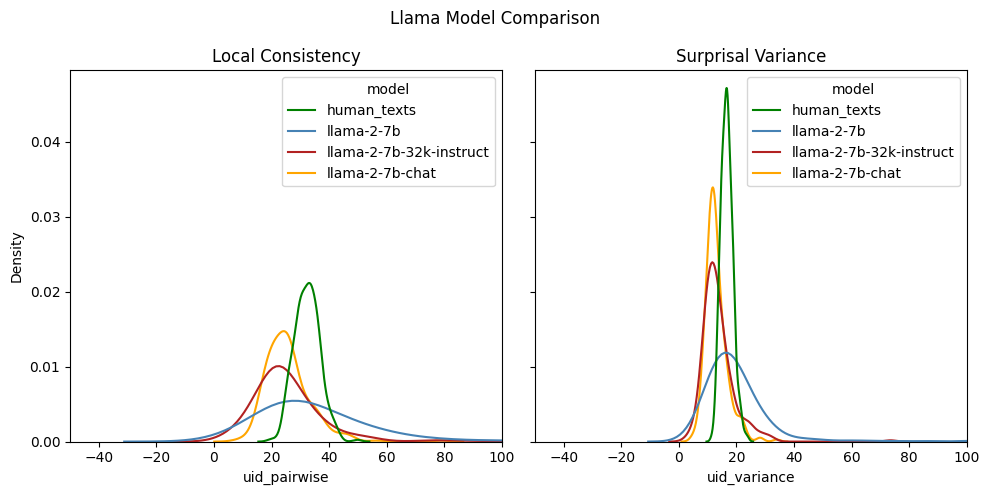

In [106]:
plot_uid_measures(llama_metrics, hue='model', suptitle="Llama model comparison", cmap=main_cmap)

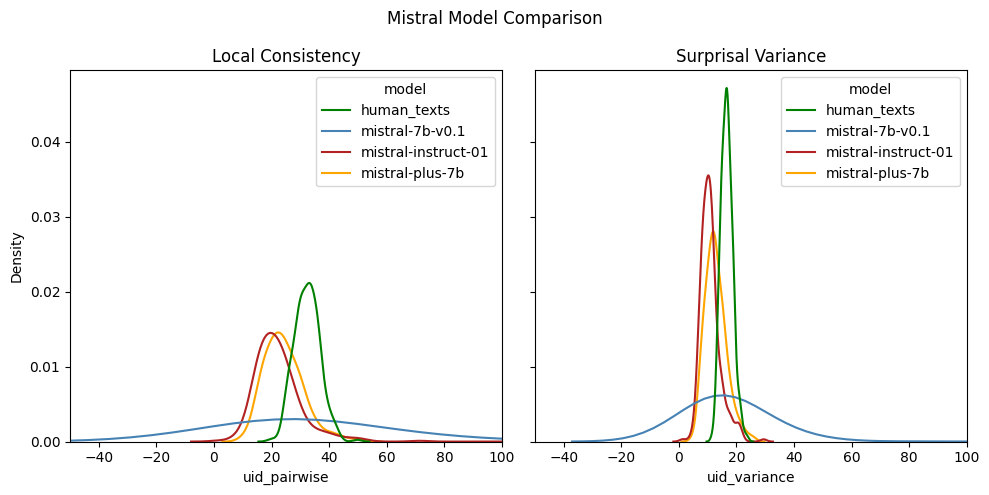

In [107]:
plot_uid_measures(mistral_metrics, hue='model', suptitle="mistral model comparison", cmap=main_cmap)

# Statistical Testing

## KS-Test

In [108]:
from scipy.stats import ks_2samp

In [109]:
# comparing models to human
metric = 'uid_variance'
n_unique_models = UID_metrics['model'].nunique()
all_models = UID_metrics['model'].unique()
model_results = dict()
for model in all_models:
    d1 = UID_metrics.loc[UID_metrics['model'] == model, metric]
    d2 = UID_metrics.loc[UID_metrics['model'] == 'human_texts', metric]
    result = ks_2samp(d1, d2, alternative="two-sided")
    model_results[model] = result
model_results

{'human_texts': KstestResult(statistic=np.float64(0.0), pvalue=np.float64(1.0), statistic_location=np.float64(11.338586177765642), statistic_sign=np.int8(1)),
 'llama-2-7b': KstestResult(statistic=np.float64(0.2955), pvalue=np.float64(2.1438462913993263e-77), statistic_location=np.float64(20.100794017601885), statistic_sign=np.int8(-1)),
 'llama-2-7b-32k-instruct': KstestResult(statistic=np.float64(0.553), pvalue=np.float64(9.620252363063907e-75), statistic_location=np.float64(14.062003121620585), statistic_sign=np.int8(1)),
 'llama-2-7b-chat': KstestResult(statistic=np.float64(0.6178333333333333), pvalue=np.float64(4.382201874450111e-95), statistic_location=np.float64(14.054966771711786), statistic_sign=np.int8(1)),
 'mistral-7b-v0.1': KstestResult(statistic=np.float64(0.399), pvalue=np.float64(8.270760859355696e-38), statistic_location=np.float64(13.209420799630436), statistic_sign=np.int8(1)),
 'mistral-instruct-01': KstestResult(statistic=np.float64(0.7936666666666666), pvalue=np.f

In [110]:
metric = 'uid_variance'
n_unique_models = UID_metrics['model_class'].nunique()
all_model_classes = UID_metrics['model_class'].unique()
model_class_results = dict()
for model_class in all_model_classes:
    d1 = UID_metrics.loc[UID_metrics['model_class'] == model_class, metric]
    d2 = UID_metrics.loc[UID_metrics['model_class'] == 'human', metric]
    result = ks_2samp(d1, d2, alternative="two-sided")
    model_class_results[model_class] = result
model_class_results

{'human': KstestResult(statistic=np.float64(0.0), pvalue=np.float64(1.0), statistic_location=np.float64(11.338586177765642), statistic_sign=np.int8(1)),
 'base': KstestResult(statistic=np.float64(0.283), pvalue=np.float64(5.858867162014141e-76), statistic_location=np.float64(20.100794017601885), statistic_sign=np.int8(-1)),
 'instruct': KstestResult(statistic=np.float64(0.6591666666666667), pvalue=np.float64(4.021011440751329e-192), statistic_location=np.float64(13.01102194310928), statistic_sign=np.int8(1)),
 'chat': KstestResult(statistic=np.float64(0.5993333333333334), pvalue=np.float64(7.13602454719481e-156), statistic_location=np.float64(13.756461577948546), statistic_sign=np.int8(1))}

Text(0.5, 1.0, 'Ks Test Statistics For Different Models, Comparing To Human')

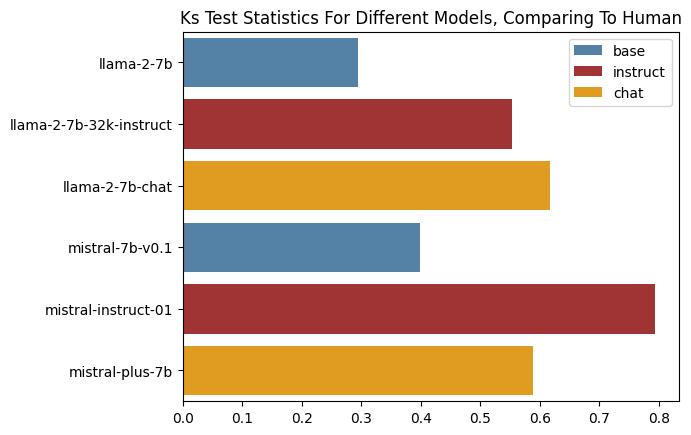

In [111]:
sns.barplot(y=list(model_results.keys())[1:], x=[result.statistic for result in model_results.values()][1:], hue=['base', 'instruct', 'chat'] * 2, palette=main_cmap)
plt.title("KS Test Statistics for different models, comparing to human".title())

Text(0.5, 1.0, '-Log(Pvalue) For Different Models, Comparing To Human')

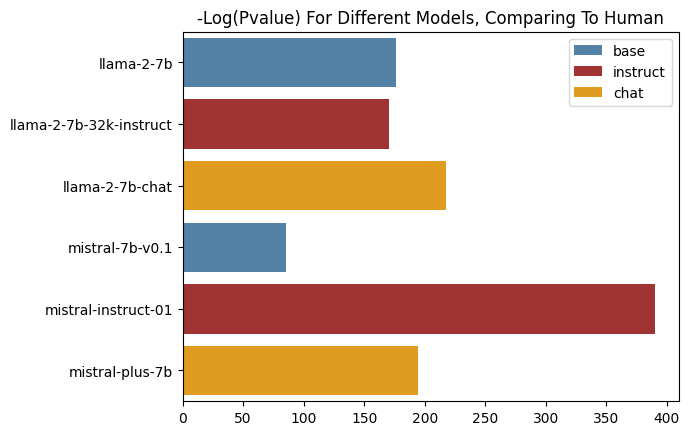

In [114]:
sns.barplot(y=list(model_results.keys())[1:], x=[-np.log(result.pvalue) for result in model_results.values()][1:], hue=['base', 'instruct', 'chat'] * 2, palette=main_cmap)
plt.title("-log(pvalue) for different models, comparing to human".title())

In [116]:
# testing effect of centering distributions
metric = 'uid_variance'
n_unique_models = UID_metrics['model'].nunique()
all_models = UID_metrics['model'].unique()
model_results = dict()
for model in all_models:
    d1 = UID_metrics.loc[UID_metrics['model'] == model, metric]
    d1 -= d1.mean()
    d2 = UID_metrics.loc[UID_metrics['model'] == 'human_texts', metric]
    d2 -= d2.mean()
    result = ks_2samp(d1, d2, alternative="two-sided")
    model_results[model] = result
model_results

{'human_texts': KstestResult(statistic=np.float64(0.0), pvalue=np.float64(1.0), statistic_location=np.float64(-5.2065832385089585), statistic_sign=np.int8(1)),
 'llama-2-7b': KstestResult(statistic=np.float64(0.468), pvalue=np.float64(2.9993355631007798e-198), statistic_location=np.float64(-3.0605661327315588), statistic_sign=np.int8(1)),
 'llama-2-7b-32k-instruct': KstestResult(statistic=np.float64(0.2771666666666667), pvalue=np.float64(3.595838020006057e-18), statistic_location=np.float64(-2.4557801822844993), statistic_sign=np.int8(1)),
 'llama-2-7b-chat': KstestResult(statistic=np.float64(0.14916666666666667), pvalue=np.float64(1.579350526583561e-05), statistic_location=np.float64(-1.8911929886334118), statistic_sign=np.int8(1)),
 'mistral-7b-v0.1': KstestResult(statistic=np.float64(0.61), pvalue=np.float64(1.872192688082596e-92), statistic_location=np.float64(-3.1635327125480224), statistic_sign=np.int8(1)),
 'mistral-instruct-01': KstestResult(statistic=np.float64(0.1318333333333

Text(0.5, 1.0, '-Log(Pvalue) For Different Models, Comparing To Human')

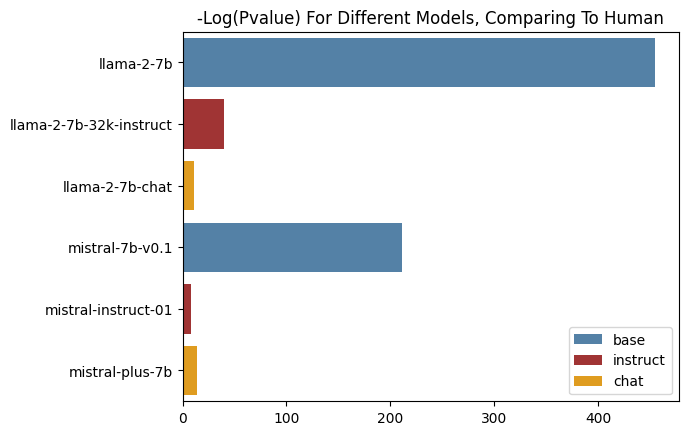

In [117]:
sns.barplot(y=list(model_results.keys())[1:], x=[-np.log(result.pvalue) for result in model_results.values()][1:], hue=['base', 'instruct', 'chat'] * 2, palette=main_cmap)
plt.title("-log(pvalue) for different models, comparing to human".title())

## KL Divergence

In [119]:
from scipy.stats import entropy

In [ ]:
model_results = dict()
for model in all_models:
    d1 = UID_metrics.loc[UID_metrics['model'] == model, metric]
    d2 = UID_metrics.loc[UID_metrics['model'] == 'human_texts', metric]
    d1 = d1.sample(min(len(d1), len(d2)))
    result = entropy(pk=d1, qk=d2)
    model_results[model] = result
model_results

ValueError: Array shapes are incompatible for broadcasting.

# Classification

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split as tts
import xgboost as xgb

## Predicting Model from UID

In [15]:
subsamp_model['model'] = pd.factorize(subsamp_model['model'], sort=True)[0]
subsamp_model['model_class'] = pd.factorize(subsamp_model['model_class'], sort=True)[0]
subsamp_model['model'].value_counts()

model
0    300
1    300
2    300
3    300
4    300
5    300
6    300
Name: count, dtype: int64

In [16]:
X = subsamp_model[['tokens', 'mean_surprisal', 'median_surprisal', 'min_surprisal', 'max_surprisal', 'uid_variance', 'uid_pairwise']]
y = subsamp_model['model_class']
X_train, X_test, y_train, y_test = tts(X, y, train_size = 0.8, random_state=42)

In [ ]:
rf_cls = RandomForestClassifier(max_depth=7, n_estimators=100)
rf_cls.fit(X_train, y_train)
rf_cls.score(X_train, y_train), rf_cls.score(X_test, y_test)

(0.7755208333333333, 0.6875)

In [ ]:
xgb_cls = xgb.XGBClassifier(max_depth=7, n_estimators=100)
xgb_cls.fit(X_train, y_train)
xgb_cls.score(X_test, y_test)

0.6520833333333333

In [ ]:
xgb_rf = xgb.XGBRFClassifier(max_depth=7, n_estimators=100)
xgb_rf.fit(X_train, y_train)
xgb_rf.score(X_test, y_test)

0.6791666666666667

## Predicting Model Class from UID

In [17]:
subsamp_model_class = (UID_metrics.groupby('model_class')
              .apply(lambda df: df.sample(300, replace=False, random_state=42))
              .reset_index(drop=True))
subsamp_model_class['model'] = pd.factorize(subsamp_model_class['model'], sort=True)[0]
subsamp_model_class['model_class'] = pd.factorize(subsamp_model_class['model_class'], sort=True)[0]
subsamp_model_class['model_class'].value_counts()

C:\Users\Tianqi Zhang\AppData\Local\Temp\ipykernel_35780\2176402028.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.sample(300, replace=False, random_state=42))


model_class
0    300
1    300
2    300
3    300
Name: count, dtype: int64

In [18]:
X = subsamp_model_class[['tokens', 'mean_surprisal', 'median_surprisal', 'min_surprisal', 'max_surprisal', 'uid_variance', 'uid_pairwise']]
y = subsamp_model_class['model_class']
X_train, X_test, y_train, y_test = tts(X, y, train_size = 0.8, random_state=42)

In [19]:
rf_cls = RandomForestClassifier(max_depth=7, n_estimators=100)
rf_cls.fit(X_train, y_train)
rf_cls.score(X_train, y_train), rf_cls.score(X_test, y_test)

(0.8697916666666666, 0.725)

In [20]:
xgb_cls = xgb.XGBClassifier(max_depth=7, n_estimators=100)
xgb_cls.fit(X_train, y_train)
xgb_cls.score(X_test, y_test)

0.675

In [21]:
xgb_rf = xgb.XGBRFClassifier(max_depth=7, n_estimators=100)
xgb_rf.fit(X_train, y_train)
xgb_rf.score(X_test, y_test)

0.7375